In [2]:
# Load and inspect the Electric Vehicle Sales by State in India dataset, then preprocess, engineer features, EDA, encode, split, model, evaluate

# 1) Imports and file reading in separate cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# Read CSV with provided encoding
file_path = 'D:/Downloads/Electric Vehicle Sales by State in India.csv'
df_ev = pd.read_csv(file_path, encoding = 'ascii')

print('Loaded dataset shape:')
print(df_ev.shape)
print('Head of dataset:')
print(df_ev.head())

Loaded dataset shape:
(96845, 8)
Head of dataset:
     Year Month_Name      Date           State         Vehicle_Class  \
0  2014.0        jan  1/1/2014  Andhra Pradesh       ADAPTED VEHICLE   
1  2014.0        jan  1/1/2014  Andhra Pradesh  AGRICULTURAL TRACTOR   
2  2014.0        jan  1/1/2014  Andhra Pradesh             AMBULANCE   
3  2014.0        jan  1/1/2014  Andhra Pradesh   ARTICULATED VEHICLE   
4  2014.0        jan  1/1/2014  Andhra Pradesh                   BUS   

  Vehicle_Category Vehicle_Type  EV_Sales_Quantity  
0           Others       Others                0.0  
1           Others       Others                0.0  
2           Others       Others                0.0  
3           Others       Others                0.0  
4              Bus          Bus                0.0  


In [3]:
# 2) Data preprocessing: fix dates, handle missing values, standardize text, remove obvious anomalies


# Copy to avoid modifying original
pre_df = df_ev.copy()

# Parse Date to datetime; some values already parsed as string like 1/1/2014
pre_df['Date'] = pd.to_datetime(pre_df['Date'], errors = 'coerce')

# Standardize Month_Name to lowercase 3-letter strings
pre_df['Month_Name'] = pre_df['Month_Name'].astype(str).str.strip().str.lower()

# Clean categorical text fields
for col in ['State', 'Vehicle_Class', 'Vehicle_Category', 'Vehicle_Type']:
    pre_df[col] = pre_df[col].astype(str).str.strip()

# Coerce numeric year and sales
pre_df['Year'] = pd.to_numeric(pre_df['Year'], errors = 'coerce')
pre_df['EV_Sales_Quantity'] = pd.to_numeric(pre_df['EV_Sales_Quantity'], errors = 'coerce')

# Drop rows with no target
pre_df = pre_df[~pre_df['EV_Sales_Quantity'].isna()]

# Remove negative sales if any
pre_df = pre_df[pre_df['EV_Sales_Quantity'] >= 0]

# Basic missingness check
missing_summary = pre_df.isna().mean().sort_values(ascending = False)

print('After preprocessing shape:')
print(pre_df.shape)
print('Missingness ratio by column (top 10):')
print(missing_summary.head(10))
print('Sample head after preprocessing:')
print(pre_df.head())

After preprocessing shape:
(96845, 8)
Missingness ratio by column (top 10):
Year                 0.0
Month_Name           0.0
Date                 0.0
State                0.0
Vehicle_Class        0.0
Vehicle_Category     0.0
Vehicle_Type         0.0
EV_Sales_Quantity    0.0
dtype: float64
Sample head after preprocessing:
     Year Month_Name       Date           State         Vehicle_Class  \
0  2014.0        jan 2014-01-01  Andhra Pradesh       ADAPTED VEHICLE   
1  2014.0        jan 2014-01-01  Andhra Pradesh  AGRICULTURAL TRACTOR   
2  2014.0        jan 2014-01-01  Andhra Pradesh             AMBULANCE   
3  2014.0        jan 2014-01-01  Andhra Pradesh   ARTICULATED VEHICLE   
4  2014.0        jan 2014-01-01  Andhra Pradesh                   BUS   

  Vehicle_Category Vehicle_Type  EV_Sales_Quantity  
0           Others       Others                0.0  
1           Others       Others                0.0  
2           Others       Others                0.0  
3           Others       

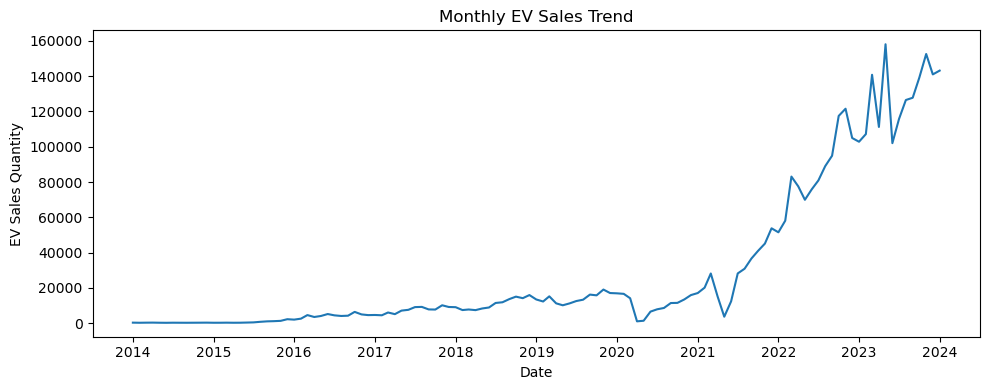

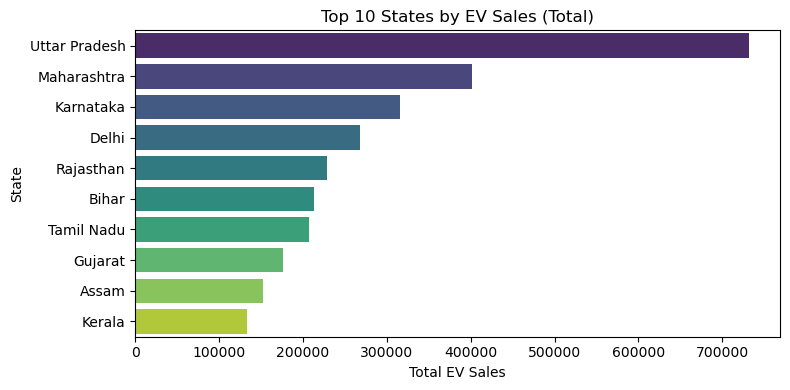

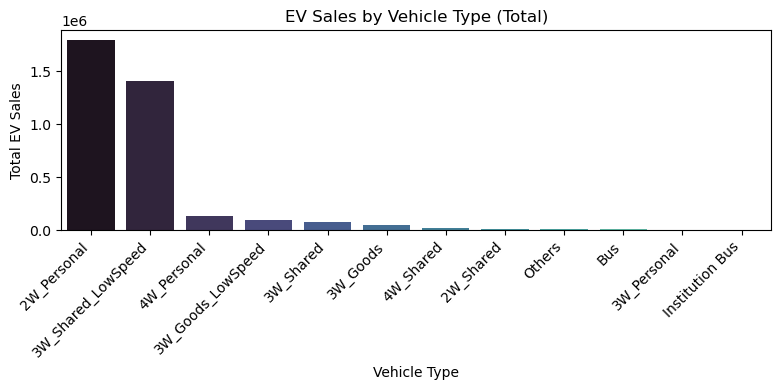

Engineered features and basic EDA completed
   year  month  EV_Sales_Quantity   date_key
0  2014      1              232.0 2014-01-01
1  2014      2              171.0 2014-02-01
2  2014      3              220.0 2014-03-01
3  2014      4              252.0 2014-04-01
4  2014      5              186.0 2014-05-01
            State  EV_Sales_Quantity
31  Uttar Pradesh           732074.0
19    Maharashtra           401535.0
15      Karnataka           315498.0
8           Delhi           268538.0
27      Rajasthan           228573.0
         Vehicle_Type  EV_Sales_Quantity
0         2W_Personal          1796340.0
6  3W_Shared_LowSpeed          1408127.0
7         4W_Personal           130676.0
3   3W_Goods_LowSpeed            90656.0
5           3W_Shared            76132.0


In [4]:
# 3) Feature engineering from date and simple aggregations for EDA

fe_df = pre_df.copy()

# Date-based features
fe_df['year'] = fe_df['Date'].dt.year
fe_df['month'] = fe_df['Date'].dt.month
fe_df['quarter'] = fe_df['Date'].dt.quarter
fe_df['month_name'] = fe_df['Date'].dt.month_name()

# Consistency check: prefer parsed year over Year if mismatch
fe_df['year'] = np.where(fe_df['Year'].notna(), fe_df['Year'].astype(int), fe_df['year'])

# EDA: overall monthly trend
monthly = fe_df.groupby(['year', 'month'], as_index = False)['EV_Sales_Quantity'].sum()
monthly['date_key'] = pd.to_datetime(monthly['year'].astype(str) + '-' + monthly['month'].astype(str) + '-01')
monthly = monthly.sort_values('date_key')

plt.figure(figsize = (10,4))
sns.lineplot(data = monthly, x = 'date_key', y = 'EV_Sales_Quantity')
plt.title('Monthly EV Sales Trend')
plt.xlabel('Date')
plt.ylabel('EV Sales Quantity')
plt.tight_layout()
plt.show()

# Top states by total sales
state_totals = fe_df.groupby('State', as_index = False)['EV_Sales_Quantity'].sum().sort_values('EV_Sales_Quantity', ascending = False).head(10)
plt.figure(figsize = (8,4))
sns.barplot(data = state_totals, x = 'EV_Sales_Quantity', y = 'State', palette = 'viridis')
plt.title('Top 10 States by EV Sales (Total)')
plt.xlabel('Total EV Sales')
plt.ylabel('State')
plt.tight_layout()
plt.show()

# Distribution by Vehicle_Type
veh_type = fe_df.groupby('Vehicle_Type', as_index = False)['EV_Sales_Quantity'].sum().sort_values('EV_Sales_Quantity', ascending = False)
plt.figure(figsize = (8,4))
sns.barplot(data = veh_type, x = 'Vehicle_Type', y = 'EV_Sales_Quantity', palette = 'mako')
plt.title('EV Sales by Vehicle Type (Total)')
plt.xlabel('Vehicle Type')
plt.ylabel('Total EV Sales')
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

print('Engineered features and basic EDA completed')
print(monthly.head())
print(state_totals.head())
print(veh_type.head())

Train size:
(31378, 6)
Test size (last 12 months):
(3814, 6)
Model Performance on Test Set (last 12 months):
              Model         MAE         RMSE        R2
0  LinearRegression  419.742226  1621.389157  0.066168
1      RandomForest  133.873983   544.780640  0.894576


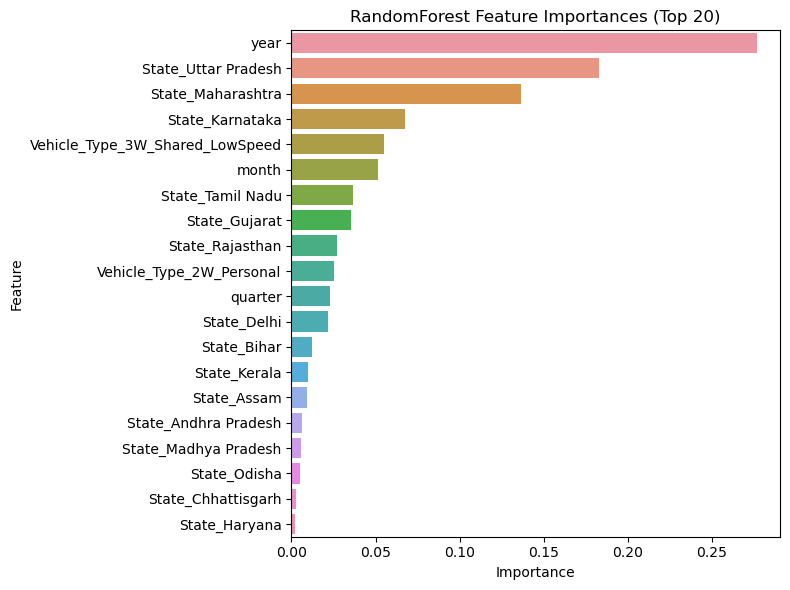

Saved performance to:
model_performance_ev_sales.csv
Saved predictions to:
model_predictions_last12m.csv


In [5]:
# Modeling: encode categoricals, split with time-awareness, train Linear Regression and RandomForest, evaluate, and show feature importances


# Use fe_df from earlier steps
model_df = fe_df.copy()

# Aggregate at a reasonable grain to reduce sparsity: State x Date x Vehicle_Type
agg_cols = ['Date', 'State', 'Vehicle_Type', 'year', 'month', 'quarter']
agg_df = model_df.groupby(agg_cols, as_index = False)['EV_Sales_Quantity'].sum()

# Sort by Date for time-aware split
agg_df = agg_df.sort_values('Date')

# Define features and target
X = agg_df.drop(columns = ['EV_Sales_Quantity'])
y = agg_df['EV_Sales_Quantity']

# Categorical and numeric columns
cat_cols = ['State', 'Vehicle_Type']
num_cols = ['year', 'month', 'quarter']

# Preprocess
numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median'))
])

categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

preprocess = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ], remainder = 'drop'
)

# Time-aware split: last 12 months as test
last_date = agg_df['Date'].max()
cutoff_date = last_date - pd.DateOffset(months = 12)
train_idx = agg_df['Date'] <= cutoff_date

X_train = X[train_idx]
y_train = y[train_idx]
X_test = X[~train_idx]
y_test = y[~train_idx]

print('Train size:')
print(X_train.shape)
print('Test size (last 12 months):')
print(X_test.shape)

# Models
lin_pipeline = Pipeline(steps = [
    ('preprocess', preprocess),
    ('model', LinearRegression())
])

rf_pipeline = Pipeline(steps = [
    ('preprocess', preprocess),
    ('model', RandomForestRegressor(n_estimators = 300, random_state = 42, n_jobs = -1, max_depth = None))
])

# Fit
lin_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

# Predict
lin_pred = lin_pipeline.predict(X_test)
rf_pred = rf_pipeline.predict(X_test)

# Evaluate
results = []
for name, preds in [('LinearRegression', lin_pred), ('RandomForest', rf_pred)]:
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared = False)
    r2 = r2_score(y_test, preds)
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

res_df = pd.DataFrame(results)
print('Model Performance on Test Set (last 12 months):')
print(res_df)

# Feature importance for RF
rf_model = rf_pipeline.named_steps['model']
# Get feature names from preprocess
onehot = rf_pipeline.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = list(onehot.get_feature_names_out(cat_cols))
feature_names = num_cols + cat_feature_names

importances = pd.Series(rf_model.feature_importances_, index = feature_names).sort_values(ascending = False)

# Plot feature importances (top 20)
plt.figure(figsize = (8,6))
sns.barplot(x = importances.head(20), y = importances.head(20).index)
plt.title('RandomForest Feature Importances (Top 20)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Save predictions for the test period for inspection
pred_df = X_test.copy()
pred_df['y_true'] = y_test.values
pred_df['y_pred_rf'] = rf_pred
pred_df['y_pred_lin'] = lin_pred
pred_df = pred_df.sort_values(['Date', 'State', 'Vehicle_Type'])

# Save files
perf_filename = 'model_performance_ev_sales.csv'
pred_filename = 'model_predictions_last12m.csv'
res_df.to_csv(perf_filename, index = False)
pred_df.to_csv(pred_filename, index = False)

print('Saved performance to:')
print(perf_filename)
print('Saved predictions to:')
print(pred_filename)

In [6]:
# computing RMSE manually.


# Recompute metrics without 'squared' parameter
mae_lin = mean_absolute_error(y_test, lin_pred)
mse_lin = mean_squared_error(y_test, lin_pred)
rmse_lin = np.sqrt(mse_lin)
r2_lin = r2_score(y_test, lin_pred)

mae_rf = mean_absolute_error(y_test, rf_pred)
mse_rf = mean_squared_error(y_test, rf_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, rf_pred)

res_df = pd.DataFrame([
    {'Model': 'LinearRegression', 'MAE': mae_lin, 'RMSE': rmse_lin, 'R2': r2_lin},
    {'Model': 'RandomForest', 'MAE': mae_rf, 'RMSE': rmse_rf, 'R2': r2_rf}
])

print('Fixed metrics computed successfully')
print(res_df)

# Save performance file and keep previous predictions
perf_filename = 'model_performance_ev_sales.csv'
res_df.to_csv(perf_filename, index = False)
print('Saved performance to:')
print(perf_filename)

Fixed metrics computed successfully
              Model         MAE         RMSE        R2
0  LinearRegression  419.742226  1621.389157  0.066168
1      RandomForest  133.873983   544.780640  0.894576
Saved performance to:
model_performance_ev_sales.csv
